In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# For reproducibility
np.random.seed(42)

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sudarshanvaidya/random-images-for-face-emotion-recognition")

print("Path to dataset files:", path)

c:\Users\Scott\OneDrive\Desktop\CSC 566\Multimodal-Emotion-Recognition\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Scott\.cache\kagglehub\datasets\sudarshanvaidya\random-images-for-face-emotion-recognition\versions\1


In [2]:
DATA_DIR = "random-images-for-face-emotion-recognition"

emotions = sorted(os.listdir(DATA_DIR))
print("Emotions:", emotions)

filepaths = []
labels = []
for idx, emo in enumerate(emotions):
    emo_dir = os.path.join(DATA_DIR, emo)
    for img_path in glob(os.path.join(emo_dir, "*.png")):
        filepaths.append(img_path)
        labels.append(idx)

print(f"Found {len(filepaths)} images")

Emotions: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']
Found 5558 images


In [3]:
# Pre-allocate arrays
N = len(filepaths)
X = np.zeros((N, 224, 224, 1), dtype="float32")
y = np.array(labels, dtype="int32")

# Load and normalize
for i, fp in enumerate(filepaths):
    img = load_img(fp, color_mode="grayscale", target_size=(224,224))
    arr = img_to_array(img) / 255.0
    X[i,:,:,0] = arr[:,:,0]

# One-hot encode labels
y_cat = to_categorical(y, num_classes=len(emotions))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape,  y_test.shape)

Train: (4446, 224, 224, 1) (4446, 8)
Test:  (1112, 224, 224, 1) (1112, 8)


In [5]:
from collections import Counter
import numpy as np

# Convert one-hot encoded y_train back to class indices
y_train_labels = np.argmax(y_train, axis=1)

# Count and print class frequencies
class_counts = Counter(y_train_labels)

for class_index, count in sorted(class_counts.items()):
    print(f"Class {class_index} ({emotions[class_index]}): {count} samples")


Class 0 (anger): 712 samples
Class 1 (contempt): 166 samples
Class 2 (disgust): 351 samples
Class 3 (fear): 456 samples
Class 4 (happiness): 1125 samples
Class 5 (neutrality): 419 samples
Class 6 (sadness): 597 samples
Class 7 (surprise): 620 samples


In [8]:
import albumentations as A
import cv2
import numpy as np

augment_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=10, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=10, p=0.3),
    A.GaussNoise(var_limit=(5.0, 10.0), p=0.1),
])



/Users/ethan/.pyenv/versions/venv/lib/python3.12/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/db/z1b_vlyx6z50n353tspswlc80000gn/T/ipykernel_55427/307703773.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 10.0), p=0.1),


In [9]:
from collections import Counter
import random

def augment_to_balance(X_train, y_train, target_count, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    
    # Decode from one-hot to class index
    y_labels = np.argmax(y_train, axis=1)
    class_counts = Counter(y_labels)

    X_aug, y_aug = [], []

    for class_idx, count in class_counts.items():
        if count >= target_count:
            continue  # skip well-represented classes like happiness 

        # Augment to reach target_count
        needed = target_count - count
        indices = np.where(y_labels == class_idx)[0]
        chosen_indices = np.random.choice(indices, size=needed, replace=True)

        for idx in chosen_indices:
            img = X_train[idx]  # shape (224, 224, 1)
            img_uint8 = (img * 255).astype(np.uint8)
            img_aug = augment_transform(image=img_uint8)['image']
            img_aug = img_aug.astype(np.float32) / 255.0
            img_aug = img_aug.reshape(224, 224, 1)

            X_aug.append(img_aug)
            y_aug.append(class_idx)

    # Stack augmented data and one-hot encode labels
    X_aug = np.stack(X_aug)
    y_aug = np.array(y_aug)
    y_aug_cat = to_categorical(y_aug, num_classes=y_train.shape[1])

    # Combine with original data
    X_combined = np.concatenate([X_train, X_aug], axis=0)
    y_combined = np.concatenate([y_train, y_aug_cat], axis=0)

    return X_combined, y_combined


In [10]:
X_train_balanced, y_train_balanced = augment_to_balance(X_train, y_train, target_count=500)

print("After balancing:")
for i, emo in enumerate(emotions):
    print(f"{emo}: {(y_train_balanced.argmax(axis=1) == i).sum()}")

After balancing:
anger: 712
contempt: 500
disgust: 500
fear: 500
happiness: 1125
neutrality: 500
sadness: 597
surprise: 620


In [12]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D, SeparableConv2D, BatchNormalization, Activation,
    MaxPooling2D, GlobalAveragePooling2D, Dense, Add
)
from tensorflow.keras.optimizers import Adam

def entry_flow(inputs):
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728]:
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        # Project residual
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = Add()([x, residual])
        previous_block_activation = x

    return x

def middle_flow(x, num_blocks=8):
    previous_block_activation = x
    for _ in range(num_blocks):
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

def exit_flow(x, num_classes):
    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

# === build and compile the model ===
input_shape = (224, 224, 1)       # grayscale input
num_classes = len(emotions) # your eight emotions

inputs = Input(shape=input_shape)
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=8)
outputs = exit_flow(x, num_classes)

model = Model(inputs, outputs, name="XCeption_like")

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "XCeption_like"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 112, 112,  │      8,896 │ activation_2[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 112, 112,  │     17,664 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │      8,320 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 17,643,744 (67.31 MB)

 Trainable params: 17,597,152 (67.13 MB)

 Non-trainable params: 46,592 (182.00 KB)

In [13]:
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.1,
    epochs=20,
    batch_size=32
)

Epoch 1/20
  3/143 ━━━━━━━━━━━━━━━━━━━━ 11:36 5s/step - accuracy: 0.2431 - loss: 2.0351

KeyboardInterrupt: 

In [12]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4%}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 753ms/step - accuracy: 0.4947 - loss: 2.3879
Test loss: 2.3443, Test accuracy: 49.7302%


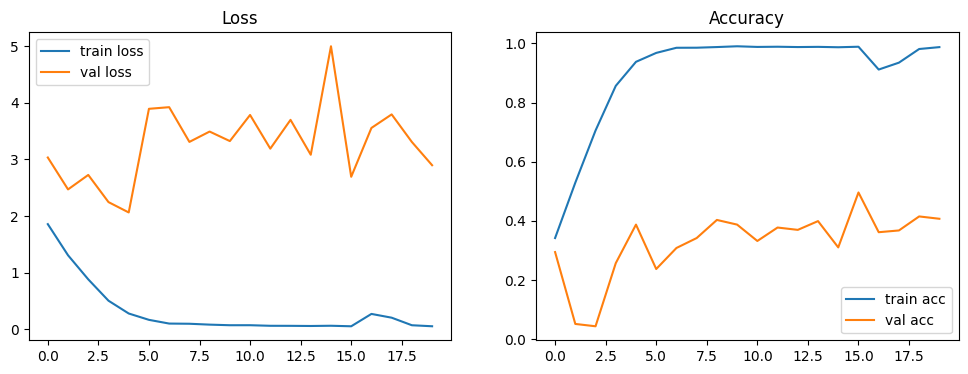

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"],   label="val loss")
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend(); plt.title("Accuracy")

plt.show()

In [ ]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert one-hot to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()



In [14]:
model.save("Models/face_emotion_vggnet_augmented_20_epochs.h5")
print("Model saved to face_emotion_vggnet_augmented_20_epochs.h5")

Model saved to face_emotion_vggnet_augmented_20_epochs.h5
